In [1]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder\
    .config("spark.executor.memory", '16g') \
    .config('spark.executor.cores', '2') \
    .config('spark.cores.max', '8') \
    .config("spark.driver.memory",'16g') \
    .config("spark.driver.maxResultSize", '2g') \
    .getOrCreate()

sc = spark.sparkContext


In [2]:
import os
os.chdir("/project/ds5559/BioNerds")

clean_df = spark.read.load("/project/ds5559/BioNerds/clean_features.parquet2")
clean_df.show(5)

+------------+-----------+------------+---+---------+----+------+---------------+--------------------+--------------------+--------------------+
|          ID|  lesion_id|    image_id| dx|  dx_type| age|   sex|   localization|            mnet_vec|             r50_vec|            xcep_vec|
+------------+-----------+------------+---+---------+----+------+---------------+--------------------+--------------------+--------------------+
|ISIC_0024306|HAM_0000550|ISIC_0024306| nv|follow_up|45.0|  male|          trunk|[0.0,0.0,0.0,0.0,...|[0.24354705214500...|[0.0,0.0,0.0,0.0,...|
|ISIC_0024387|HAM_0004156|ISIC_0024387| nv|    histo|65.0|female|lower extremity|[0.0,1.3627424240...|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|ISIC_0024397|HAM_0001501|ISIC_0024397| nv|follow_up|65.0|  male|          trunk|[0.0,0.0,0.0,0.0,...|[1.18369388580322...|[0.0,0.0,0.0,0.0,...|
|ISIC_0024551|HAM_0002629|ISIC_0024551| nv|follow_up|50.0|  male|        abdomen|[0.0,0.0,0.0,0.0,...|[0.01115676853805...|[0.0,0.

In [13]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.feature import PCA
import numpy as np
VA = VectorAssembler(inputCols=["mnet_vec", "xcep_vec"], outputCol="all_features")

In [4]:
small_feature = VA.transform(clean_df)

In [5]:
small_feature.show(5)

+------------+-----------+------------+---+---------+----+------+---------------+--------------------+--------------------+--------------------+--------------------+
|          ID|  lesion_id|    image_id| dx|  dx_type| age|   sex|   localization|            mnet_vec|             r50_vec|            xcep_vec|        all_features|
+------------+-----------+------------+---+---------+----+------+---------------+--------------------+--------------------+--------------------+--------------------+
|ISIC_0024306|HAM_0000550|ISIC_0024306| nv|follow_up|45.0|  male|          trunk|[0.0,0.0,0.0,0.0,...|[0.24354705214500...|[0.0,0.0,0.0,0.0,...|(512,[6,20,22,50,...|
|ISIC_0024387|HAM_0004156|ISIC_0024387| nv|    histo|65.0|female|lower extremity|[0.0,1.3627424240...|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|(512,[1,6,22,50,6...|
|ISIC_0024397|HAM_0001501|ISIC_0024397| nv|follow_up|65.0|  male|          trunk|[0.0,0.0,0.0,0.0,...|[1.18369388580322...|[0.0,0.0,0.0,0.0,...|(512,[6,20,22,50,...|
|ISI

In [6]:
SS = StandardScaler(inputCol = "all_features", outputCol = "SS_features", withStd = True, withMean = True)
SS = SS.fit(small_feature)
trans_feature = SS.transform(small_feature)


In [7]:
trans_feature.show(5)


+------------+-----------+------------+---+---------+----+------+---------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|          ID|  lesion_id|    image_id| dx|  dx_type| age|   sex|   localization|            mnet_vec|             r50_vec|            xcep_vec|        all_features|         SS_features|
+------------+-----------+------------+---+---------+----+------+---------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|ISIC_0024306|HAM_0000550|ISIC_0024306| nv|follow_up|45.0|  male|          trunk|[0.0,0.0,0.0,0.0,...|[0.24354705214500...|[0.0,0.0,0.0,0.0,...|(512,[6,20,22,50,...|[0.0,-0.946979346...|
|ISIC_0024387|HAM_0004156|ISIC_0024387| nv|    histo|65.0|female|lower extremity|[0.0,1.3627424240...|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|(512,[1,6,22,50,6...|[0.0,-0.055280824...|
|ISIC_0024397|HAM_0001501|ISIC_0024397| nv|follow_up|65.0|  male|

In [25]:
temp_table = trans_feature.select('xcep_vec','dx')
temp_table.cache()

DataFrame[xcep_vec: vector, dx: string]

In [26]:
SS = StandardScaler(inputCol = "xcep_vec", outputCol = "SS_xcep", withStd = True, withMean = True)
SS = SS.fit(small_feature)
temp_table = SS.transform(temp_table)


In [27]:
pca = PCA(k=2,inputCol="SS_xcep", outputCol="pca_xcep")

In [28]:
%%time 
model = pca.fit(temp_table)
temp_table = model.transform(temp_table)

CPU times: user 6.45 ms, sys: 4.27 ms, total: 10.7 ms
Wall time: 2.32 s


In [29]:
np.round(100.00*model.explainedVariance.toArray(),4)

array([26.5336, 20.0454])

In [30]:
temp_table.show(5)

+--------------------+---+--------------------+--------------------+
|            xcep_vec| dx|             SS_xcep|            pca_xcep|
+--------------------+---+--------------------+--------------------+
|[0.0,0.0,0.0,0.0,...| nv|[0.0,-0.072243050...|[1.12802226382271...|
|[0.0,0.0,0.0,0.0,...| nv|[0.0,-0.072243050...|[-4.1368614358147...|
|[0.0,0.0,0.0,0.0,...| nv|[0.0,-0.072243050...|[-0.2136785870765...|
|[0.0,0.0,0.0,0.0,...| nv|[0.0,-0.072243050...|[5.75581990939208...|
|[0.0,0.0,0.0,0.0,...|mel|[0.0,-0.072243050...|[-0.1564180883516...|
+--------------------+---+--------------------+--------------------+
only showing top 5 rows



In [31]:
import pyspark.sql.functions as F
from pyspark.sql.types import FloatType


firstelement=F.udf(lambda v:float(v[0]),FloatType())
secondelement=F.udf(lambda v:float(v[1]),FloatType())


In [32]:
temp_table = temp_table.withColumn("P1",firstelement("pca_xcep"))
temp_table = temp_table.withColumn("P2",secondelement("pca_xcep"))
temp_table.show(5)

+--------------------+---+--------------------+--------------------+-----------+-----------+
|            xcep_vec| dx|             SS_xcep|            pca_xcep|         P1|         P2|
+--------------------+---+--------------------+--------------------+-----------+-----------+
|[0.0,0.0,0.0,0.0,...| nv|[0.0,-0.072243050...|[1.12802226382271...|  1.1280223|  2.6993928|
|[0.0,0.0,0.0,0.0,...| nv|[0.0,-0.072243050...|[-4.1368614358147...| -4.1368613| -3.6448934|
|[0.0,0.0,0.0,0.0,...| nv|[0.0,-0.072243050...|[-0.2136785870765...|-0.21367858|-0.57080823|
|[0.0,0.0,0.0,0.0,...| nv|[0.0,-0.072243050...|[5.75581990939208...|    5.75582|   3.315424|
|[0.0,0.0,0.0,0.0,...|mel|[0.0,-0.072243050...|[-0.1564180883516...|-0.15641809|   8.771501|
+--------------------+---+--------------------+--------------------+-----------+-----------+
only showing top 5 rows



In [33]:
tableA =  temp_table.toPandas()

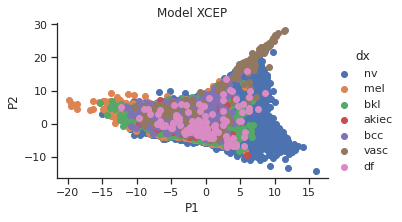

In [35]:
from  matplotlib import pyplot
import seaborn as sns
sns.set(style='ticks')
%matplotlib inline


fg = sns.FacetGrid(data=tableA, hue='dx', aspect=1.61)
fg.map(pyplot.scatter, 'P1', 'P2').add_legend()
fg.set(title = "Model XCEP")

In [36]:
temp_table = trans_feature.select('mnet_vec','dx')
temp_table.cache()
SS = StandardScaler(inputCol = "mnet_vec", outputCol = "SS_mnet", withStd = True, withMean = True)
SS = SS.fit(small_feature)
temp_table = SS.transform(temp_table)

In [37]:
pca = PCA(k=2,inputCol="SS_mnet", outputCol="pca_mnet")
model = pca.fit(temp_table)
temp_table = model.transform(temp_table)

In [38]:
firstelement=F.udf(lambda v:float(v[0]),FloatType())
secondelement=F.udf(lambda v:float(v[1]),FloatType())
temp_table = temp_table.withColumn("P1",firstelement("pca_mnet"))
temp_table = temp_table.withColumn("P2",secondelement("pca_mnet"))
temp_table.show(5)

+--------------------+---+--------------------+--------------------+----------+-----------+
|            mnet_vec| dx|             SS_mnet|            pca_mnet|        P1|         P2|
+--------------------+---+--------------------+--------------------+----------+-----------+
|[0.0,0.0,0.0,0.0,...| nv|[0.0,-0.946979346...|[2.34198328796517...| 2.3419833|-0.53216153|
|[0.0,1.3627424240...| nv|[0.0,-0.055280824...|[-2.4838799884825...|  -2.48388|  -1.974106|
|[0.0,0.0,0.0,0.0,...| nv|[0.0,-0.946979346...|[6.23858286909946...|  6.238583|  1.4790857|
|[0.0,0.0,0.0,0.0,...| nv|[0.0,-0.946979346...|[3.50683487461766...|  3.506835|-0.39793918|
|[0.0,2.0978577136...|mel|[0.0,0.4257354015...|[-2.9202636772138...|-2.9202638| -0.7284618|
+--------------------+---+--------------------+--------------------+----------+-----------+
only showing top 5 rows



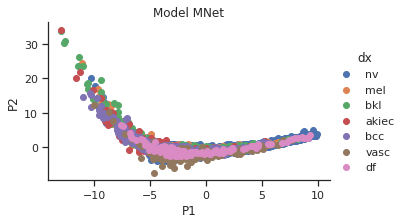

In [39]:
tableA =  temp_table.toPandas()
fg = sns.FacetGrid(data=tableA, hue='dx', aspect=1.61)
fg.map(pyplot.scatter, 'P1', 'P2').add_legend()
fg.set(title = "Model MNet")

In [40]:
temp_table = trans_feature.select('r50_vec','dx')
temp_table.cache()
SS = StandardScaler(inputCol = "r50_vec", outputCol = "SS_r50", withStd = True, withMean = True)
SS = SS.fit(small_feature)
temp_table = SS.transform(temp_table)

In [41]:
pca = PCA(k=2,inputCol="SS_r50", outputCol="pca_r50")
model = pca.fit(temp_table)
temp_table = model.transform(temp_table)

In [42]:
firstelement=F.udf(lambda v:float(v[0]),FloatType())
secondelement=F.udf(lambda v:float(v[1]),FloatType())
temp_table = temp_table.withColumn("P1",firstelement("pca_r50"))
temp_table = temp_table.withColumn("P2",secondelement("pca_r50"))
temp_table.show(5)

+--------------------+---+--------------------+--------------------+-----------+----------+
|             r50_vec| dx|              SS_r50|             pca_r50|         P1|        P2|
+--------------------+---+--------------------+--------------------+-----------+----------+
|[0.24354705214500...| nv|[-0.0150539054586...|[-9.6294016712040...|  -9.629401|  5.488492|
|[0.0,0.0,0.0,0.0,...| nv|[-0.5136019958432...|[-0.8526972564024...|-0.85269725| -7.495711|
|[1.18369388580322...| nv|[1.90945474481378...|[-8.8973434062292...|  -8.897344| 11.865739|
|[0.01115676853805...| nv|[-0.4907637573980...|[-8.8110161989271...|  -8.811016|  1.166412|
|[0.0,0.0,0.0,0.0,...|mel|[-0.5136019958432...|[12.6229300755389...|  12.622931|-11.177798|
+--------------------+---+--------------------+--------------------+-----------+----------+
only showing top 5 rows



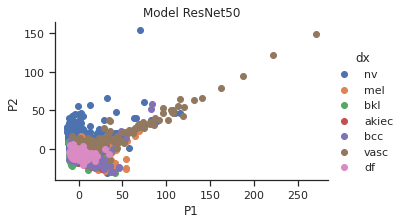

In [43]:
tableA =  temp_table.toPandas()
fg = sns.FacetGrid(data=tableA, hue='dx', aspect=1.61)
fg.map(pyplot.scatter, 'P1', 'P2').add_legend()
fg.set(title = "Model ResNet50")